# Player career

**Game Score** is a metric created by Dom Luszczyszyn (The Athletic) to quantify a player’s performance in a single game, assigning specific weights to on-ice results. Dom first developed the formula in 2016, weighting goals, primary assists, secondary assists, shots on goal, blocked shots, penalty differential, faceoffs, 5-on-5 Corsi differential, and 5-on-5 goal differential. In this initial version, forwards and defensemen were evaluated equally. In 2020, he updated the metric: Corsi was replaced with xG (Expected Goals), and weights were adjusted differently for the two player types. The formula for goaltenders remained unchanged.

Reference: [NHL.com](https://www.nhl.com/kraken/news/evaluating-single-game-performances-using-game-score-330146096), [NY Times](https://www.nytimes.com/athletic/1019070/2019/06/14/improving-our-nhl-projection-model-ahead-of-the-2019-20-season/), [Hockey Graphs](https://hockey-graphs.com/2016/07/13/measuring-single-game-productivity-an-introduction-to-game-score/) (original calculation)

### Import libraries

In [41]:
import sys
import os
import pandas as pd

In [42]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [43]:
from utils import data_cleaning
from utils import distribution_analysis as da
from utils import discrete_distribution_models as ddm
from utils import feature_engineering
from utils import correlation_analysis
from utils import hypothesis_testing
from utils import regression_analysis

### Import the dataset

In [49]:
matthews_df = "https://moneypuck.com/moneypuck/playerData/careers/gameByGame/regular/skaters/8479318.csv"
df = pd.read_csv(matthews_df)
df.head(5)

,playerId,season,name,gameId,playerTeam,opposingTeam,home_or_away,gameDate,position,situation,...,OffIce_F_xGoals,OffIce_A_xGoals,OffIce_F_shotAttempts,OffIce_A_shotAttempts,xGoalsForAfterShifts,xGoalsAgainstAfterShifts,corsiForAfterShifts,corsiAgainstAfterShifts,fenwickForAfterShifts,fenwickAgainstAfterShifts
0,8479318,2016,Auston Matthews,2016020001,TOR,OTT,AWAY,20161012,C,other,...,0.000,0.176,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8479318,2016,Auston Matthews,2016020001,TOR,OTT,AWAY,20161012,C,all,...,1.082,1.820,52.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8479318,2016,Auston Matthews,2016020001,TOR,OTT,AWAY,20161012,C,5on5,...,1.033,1.266,44.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8479318,2016,Auston Matthews,2016020001,TOR,OTT,AWAY,20161012,C,4on5,...,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8479318,2016,Auston Matthews,2016020001,TOR,OTT,AWAY,20161012,C,5on4,...,0.049,0.000,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Read the data

In [50]:
data_cleaning.print_df_size(df)

Number of samples: 3145
Number of features: 157


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3145 entries, 0 to 3144
Columns: 157 entries, playerId to fenwickAgainstAfterShifts
dtypes: float64(147), int64(4), object(6)
memory usage: 3.8+ MB


### Preprocessing

In [53]:
# Missing values?
data_cleaning.report_nan(df)

No missing values found.


In [54]:
df = data_cleaning.drop_duplicate_columns(df)
data_cleaning.save_column_names(df)

Removed duplicate columns: ['I_F_shifts', 'faceoffsWon', 'penalityMinutes']
Number of samples: 3145
Number of features: 154
Saved: names_columns.txt


La stessa partita viene riportata in 5 situazioni diversi: 5on5, 5on4, 4on5, other e all. Riportiamo tutto nella stessa riga.

In [55]:
import pandas as pd

df = df.pivot_table(
    index=["playerId", "season", "name", "gameId", "playerTeam", "opposingTeam", "home_or_away", "gameDate", "position", "gameScore"],
    columns="situation",
    values=[col for col in df.columns if col not in ["playerId","season","name","gameId","playerTeam","opposingTeam","home_or_away","gameDate","position","gameScore","situation"]],
    aggfunc="first"
)

df = df.reset_index()
df.columns = ['_'.join([str(c) for c in col if c]) for col in df.columns.values]

In [56]:
df = data_cleaning.drop_duplicate_columns(df)
data_cleaning.save_column_names(df)

Removed duplicate columns: ['I_F_flurryScoreVenueAdjustedxGoals_4on5', 'I_F_flurryScoreVenueAdjustedxGoals_5on4', 'I_F_flurryScoreVenueAdjustedxGoals_other', 'I_F_giveaways_4on5', 'I_F_highDangerGoals_4on5', 'I_F_lowDangerGoals_4on5', 'I_F_mediumDangerGoals_4on5', 'I_F_playStopped_4on5', 'I_F_reboundGoals_4on5', 'I_F_reboundxGoals_4on5', 'I_F_secondaryAssists_4on5', 'I_F_shotAttempts_4on5', 'I_F_shotAttempts_5on4', 'I_F_shotAttempts_other', 'I_F_unblockedShotAttempts_4on5', 'I_F_unblockedShotAttempts_5on4', 'I_F_unblockedShotAttempts_other', 'I_F_xGoals_4on5', 'I_F_xGoals_5on4', 'I_F_xGoals_other', 'I_F_xGoals_with_earned_rebounds_scoreAdjusted_4on5', 'I_F_xGoals_with_earned_rebounds_scoreAdjusted_5on4', 'I_F_xGoals_with_earned_rebounds_scoreAdjusted_other', 'OnIce_A_flurryScoreVenueAdjustedxGoals_4on5', 'OnIce_A_flurryScoreVenueAdjustedxGoals_5on4', 'OnIce_A_flurryScoreVenueAdjustedxGoals_other', 'OnIce_A_shotAttempts_4on5', 'OnIce_A_shotAttempts_5on4', 'OnIce_A_shotAttempts_other', '

In [11]:
df = df.drop(["name","playerId", "gameId", "playerTeam", "position", "season"], axis=1)
data_cleaning.print_df_size(df)

Number of samples: 1045
Number of features: 650


In [12]:
df = pd.get_dummies(df, columns=["opposingTeam", "home_or_away"])

### Random Forest

Resources: [[1](https://arxiv.org/pdf/1407.7502)] [[2](https://www.stat.cmu.edu/~larry/%3Dsml/forests.pdf?utm_source=chatgpt.com)] [[3](https://datajobs.com/data-science-repo/Random-Forest-%5BLiaw-and-Weiner%5D.pdf?utm_source=chatgpt.com)] [[4](https://www.datacamp.com/tutorial/random-forests-classifier-python?utm_source=chatgpt.com)] [[5](https://arxiv.org/pdf/1511.05741)]

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [ ]:
df_rf = df.copy() 

# Date
df_rf["gameDate"] = df["gameDate"].astype(str).str[:8]
df_rf["gameDate"] = pd.to_datetime(df_rf["gameDate"], format='%Y%m%d')
df_rf = df_rf.sort_values("gameDate")
df_rf["days_since_last_game"] = df_rf["gameDate"].diff().dt.days.fillna(0)
df_rf = df_rf.drop(["gameDate"], axis=1)

# New features
df_rf["target"] = df_rf["gameScore"].shift(-1)
df_rf["goal_last_1"] = df_rf["gameScore"].shift(1)
df_rf["goal_last_3_avg"] = df_rf["gameScore"].shift(1).rolling(window=3).mean()
df_rf["goal_last_5_avg"] = df_rf["gameScore"].shift(1).rolling(window=5).mean()

df_rf = df_rf.dropna()

In [ ]:
# Model
X = df_rf.drop(["target"], axis=1)
y = df_rf["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    oob_score=True
)

In [ ]:
rf.fit(X_train, y_train)

print(f'Out-of-Bag Score: {rf.oob_score_}')

y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

last_game = X.iloc[[-1]]
game_score_pred = rf.predict(last_game)
print("Prediction Game Score next game:", round(game_score_pred[0], 3))

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature importances:")
print(importances)

RMSE: 1.0193282683467482
Prediction Game Score next game: 0.907

Feature importances:
offIce_fenwickPercentage_all                                0.012423
I_F_flyShiftEnds_all                                        0.009830
I_F_xGoalsFromActualReboundsOfShots_all                     0.009420
I_F_xGoals_with_earned_rebounds_scoreFlurryAdjusted_5on5    0.008351
OnIce_A_mediumDangerxGoals_all                              0.007897
                                                              ...   
I_F_rebounds_4on5                                           0.000000
opposingTeam_NYR                                            0.000000
I_F_blockedShotAttempts_4on5                                0.000000
opposingTeam_PIT                                            0.000000
opposingTeam_S.J                                            0.000000
Length: 689, dtype: float64


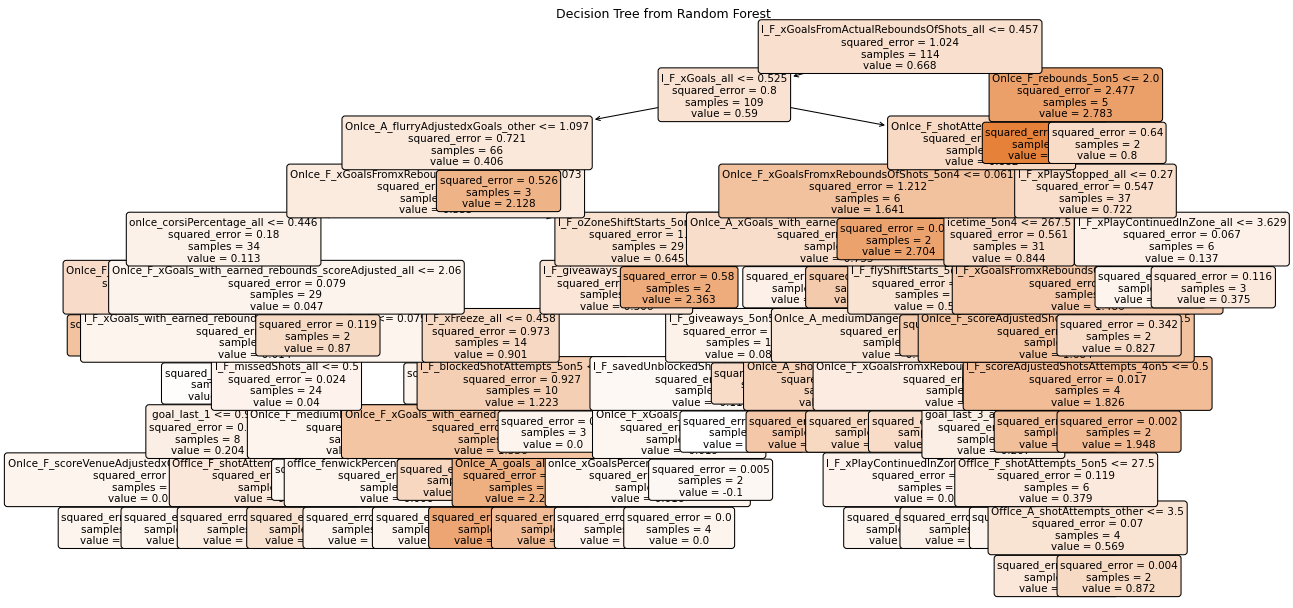

In [ ]:


tree_to_plot = rf.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=df_rf.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()

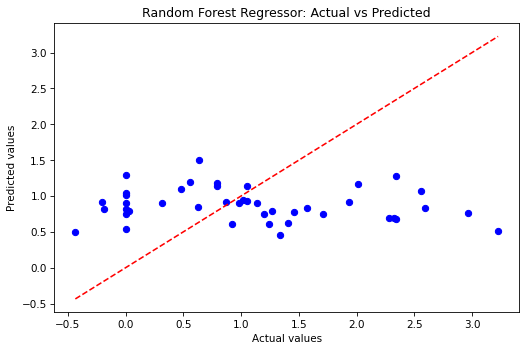

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Random Forest Regressor: Actual vs Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.show()